In [1]:
import pip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import random as rand
import copy
import time

from ucimlrepo import fetch_ucirepo

def column(X, d):
    return [row[d] for row in X]

def randindices(arr, n):
    uniqueindices=rand.sample(range(len(arr)), n)

    return uniqueindices
    
#Task 1 Part 1

# fetch dataset
wine = fetch_ucirepo(id=109)

# data (as pandas dataframes)
winefeatures = wine.data.features
#inserting bias
if winefeatures.iloc[0][0]!=1:
    winefeatures.insert(0, "Bias", [1]*len(winefeatures.index), True)
winefeaturesnp=winefeatures.to_numpy()

#Using avg, std normalization for wine features.  
MUX=[np.average(column(winefeaturesnp, d)) for d in range(len(winefeaturesnp[0]))]
SIGMAX=[np.std(column(winefeaturesnp, d)) for d in range(len(winefeaturesnp[0]))]

for d in range(len(winefeaturesnp[0])):
    for n in range(len(winefeaturesnp)):
        winefeaturesnp[n][d]=(winefeaturesnp[n][d]-MUX[d])/SIGMAX[d] if SIGMAX[d]!=0 else 0
        
winetargets = [wine.data.targets.to_numpy()[i][0] for i in range(len(wine.data.targets.to_numpy()))]

bostondb=pd.read_csv("boston.csv")
cleaneddb=bostondb.drop(bostondb.columns[11], axis=1)
#inserting bias
if cleaneddb.iloc[0][0]!=1:
    cleaneddb.insert(0, "Bias", [1]*len(cleaneddb.index), True)   
cleaneddbnp=cleaneddb.to_numpy()
MAXX=[np.max(column(cleaneddbnp, d)) for d in range(len(cleaneddbnp[0]))]

#Using max normalization for housing database.
for d in range(len(cleaneddbnp[0])):
    for n in range(len(cleaneddbnp)):
        cleaneddbnp[n][d]/=MAXX[d]

cleaneddbtargets=bostondb["MEDV"].to_numpy()
MAXY=np.max(cleaneddbtargets)
cleaneddbtargets=[cleaneddbtargets[i]/MAXY for i in range(len(cleaneddbtargets))]

C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_23844\1181958334.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if winefeatures.iloc[0][0]!=1:
C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_23844\1181958334.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if cleaneddb.iloc[0][0]!=1:


C:\Users\Shiyan Liu\AppData\Local\Temp\ipykernel_23844\2052729433.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ele=cleaneddb.iloc[j][i]


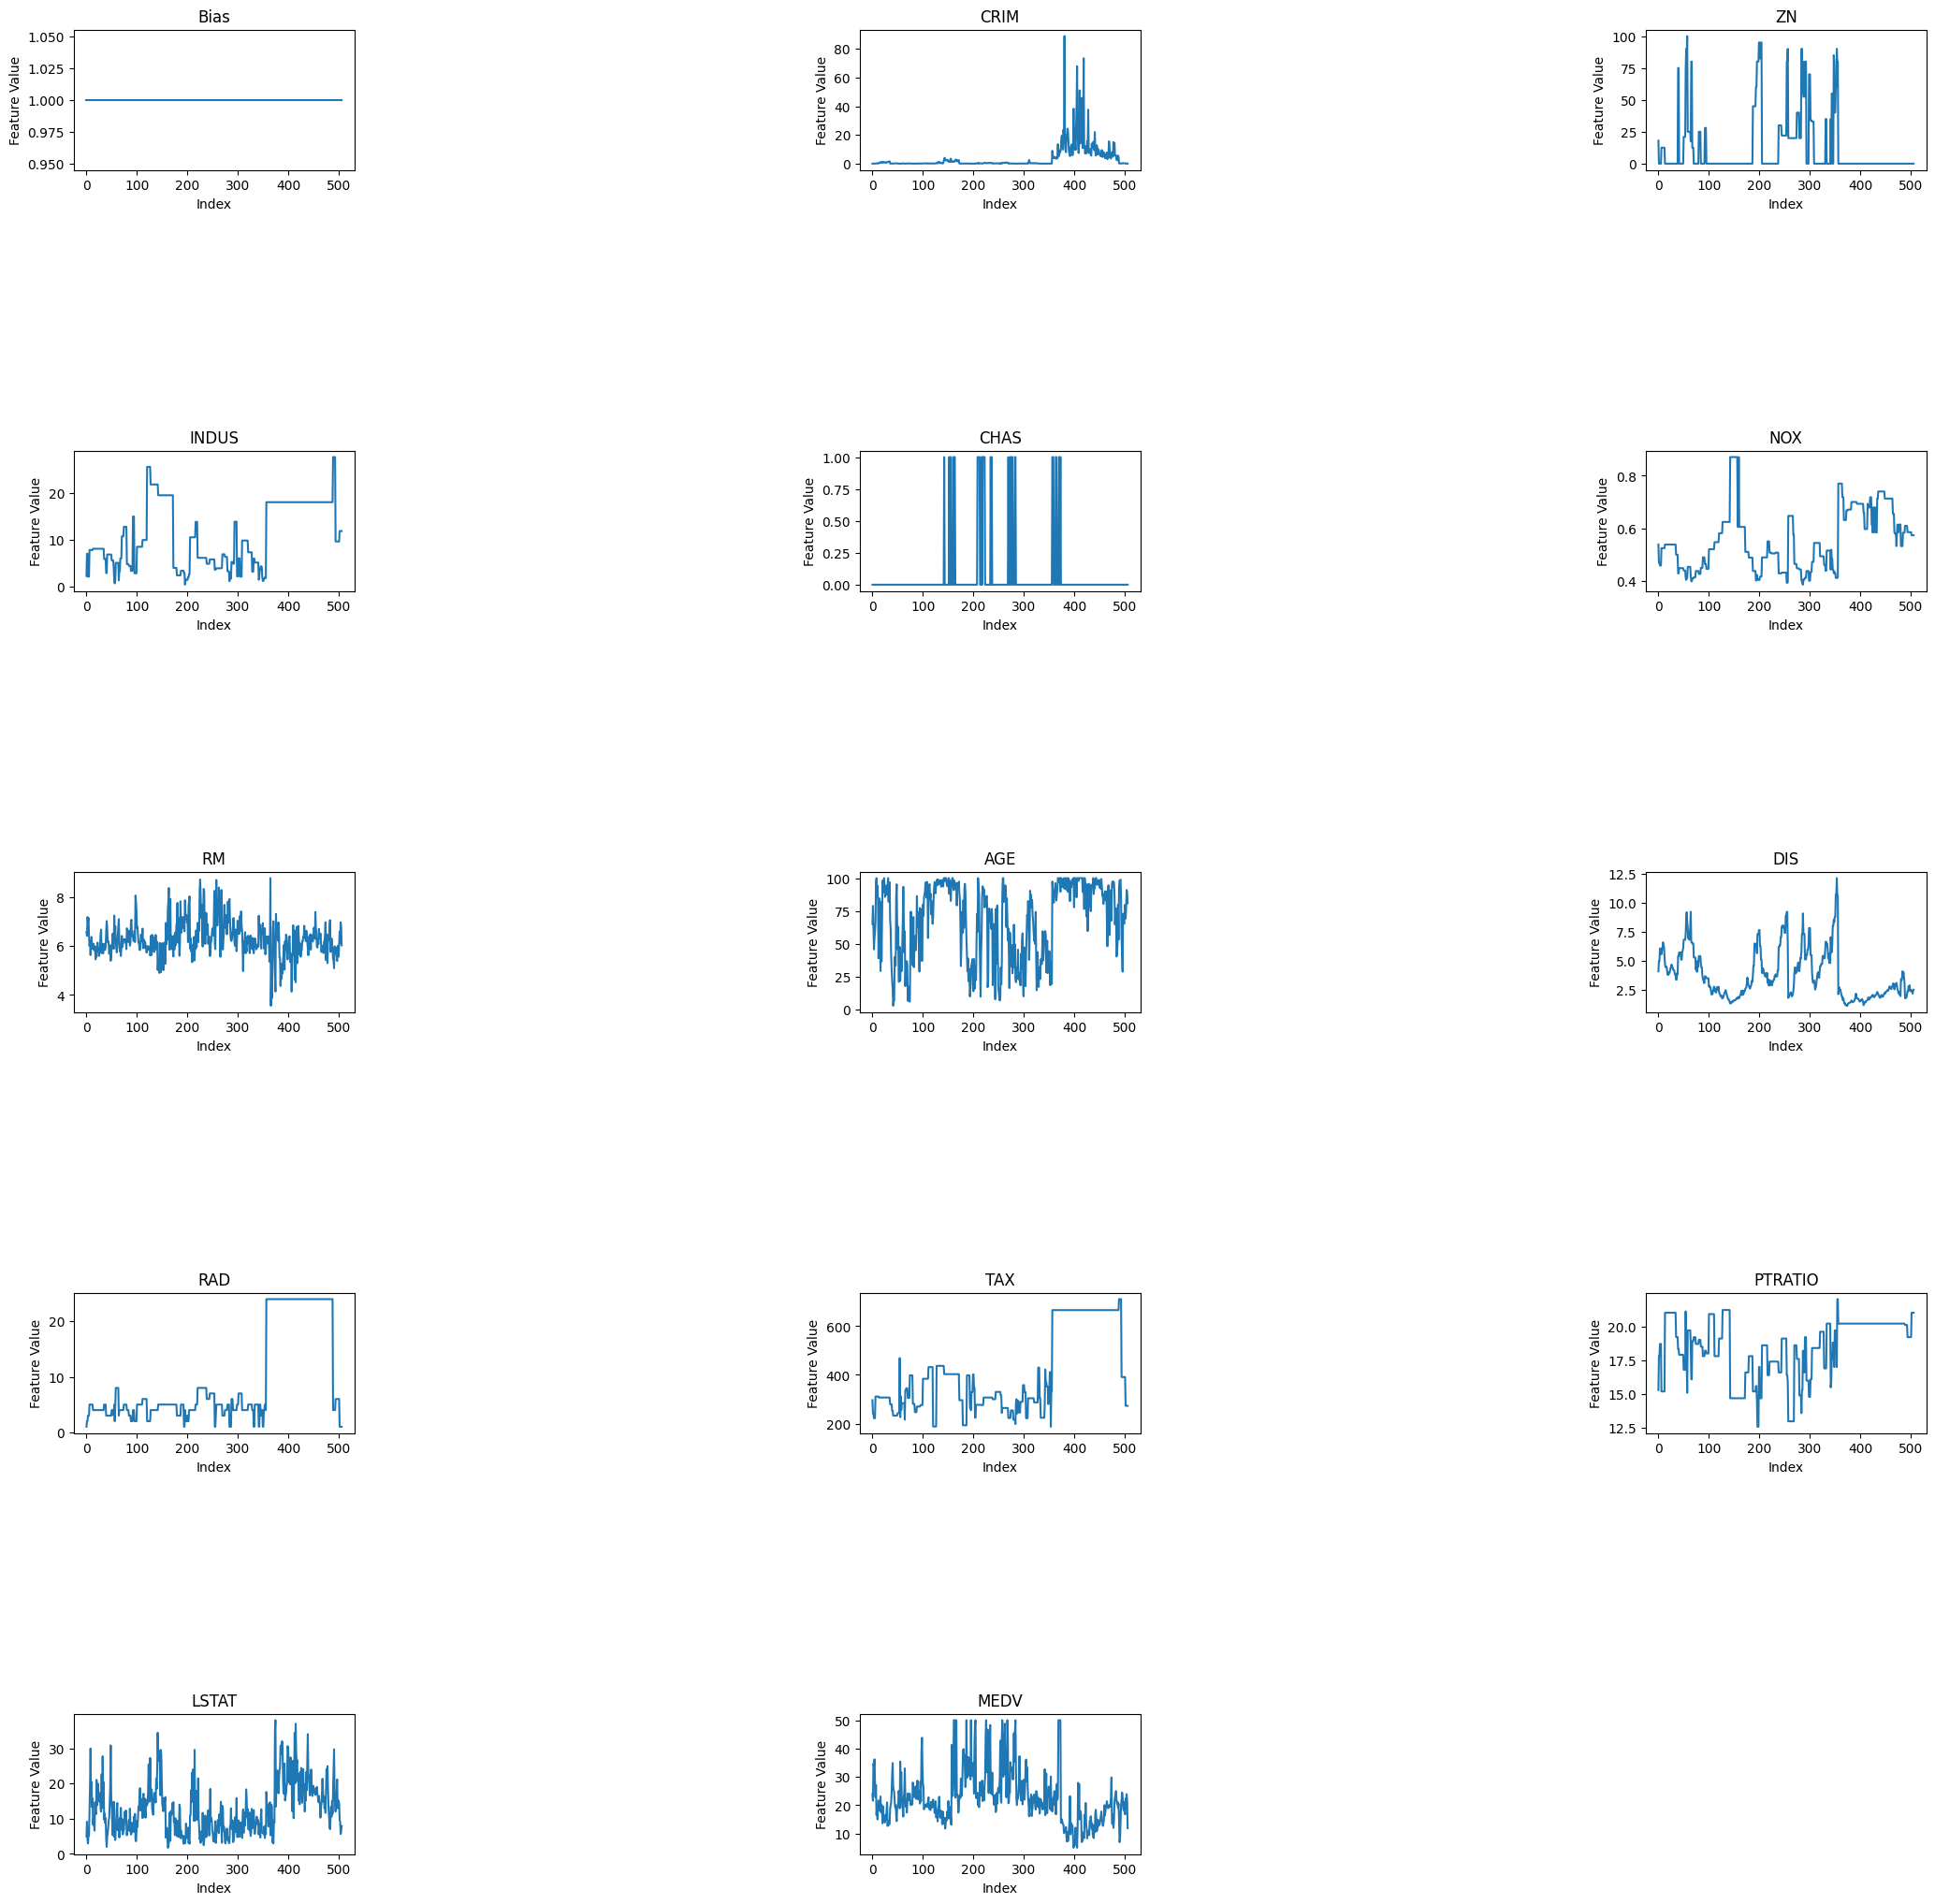

In [2]:
#Task 1 Part 3:
a=[[] for i in range(len(cleaneddb.columns))]

for i in range(len(cleaneddb.columns)):
  arr=[]
  for j in range(len(cleaneddb.index)):
    ele=cleaneddb.iloc[j][i]
    arr.append(ele)
  a[i]=arr

plt.rcParams["figure.figsize"] = [30,30]

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=2)

for i in range(len(a)):
  plt.subplot(6, 6, 2*i+1)
  plt.plot(range(len(cleaneddb.index)), a[i])
  plt.xlabel("Index")
  plt.ylabel("Feature Value")
  feature=str(cleaneddb.columns[i])
  plt.title(feature)

In [4]:
#Part 2, Task 1

class LinReg(object):
  def __init__(self, X, Y, miniBatch=0):
    self.X=X
    self.Y=Y
    self.w=None
    self.miniBatch=miniBatch
    
  def fitlinear(self):
    Xmatrix=self.X
    XT=np.transpose(self.X)
    inv=np.linalg.inv(np.matmul(XT, Xmatrix))
    a=np.matmul(XT, self.Y)
    self.w=np.matmul(inv, a)

  def fitlogistic(self, eps, alpha):
    lr=alpha
    #w=[-1]*len(self.X[0])
    w=[0]*len(self.X[0])
    n=0
    while 1:
        gradient=self.gradient(self.X, w)
        if np.linalg.norm(gradient)<eps or n>10000:
            break
        for d in range(len(w)):
            #w[d]-=lr*gradient[d]
            w[d]-=lr*gradient[d]
        n+=1
    self.w=w
  
  def fitlogisticmomentum(self, eps, alpha, beta):
    lr=alpha
    b=beta
    #w=[-1]*len(self.X[0])
    w=[0]*len(self.X[0])
    deltaw=[0]*len(self.X[0])
    n=0
    while 1:
        gradient=self.gradient(self.X, w)
        if np.linalg.norm(gradient)<eps or n>10000:
            break
        for d in range(len(w)):
            deltaw[d]=b*deltaw[d]+(1-b)*gradient[d]
            w[d]-=lr*deltaw[d]
        n+=1
    self.w=w            
    
  def gradient(self, X, w):
    gradient=[0]*len(self.X[0]) #D length vector
    if self.miniBatch!=0:
      indices=randindices(self.X, self.miniBatch)
      batch=self.batch(indices)
      yhat=np.matmul(batch, w)
      y=[self.Y[ele] for ele in indices]
      yhminusy=[yhat[b]-y[b] for b in range(len(y))]
      gradient=(1/self.miniBatch)*np.matmul(np.transpose(batch),yhminusy)
    else:
      yhat=np.matmul(X, w)
      yhminusy=[yhat[b]-self.Y[b] for b in range(len(self.Y))]
      N=len(self.Y)
      gradient=(1/N)*np.matmul(np.transpose(self.X),yhminusy)
    return gradient

  def batch(self, randindices):
    batch=[self.X[ele] for ele in randindices]
    return batch

  def getMSE(self, Xtest, Ytest):
      Ypredicted=self.predictlinear(Xtest)
      Yhminusy=np.subtract(Ypredicted, Ytest)
      return ((np.linalg.norm(Yhminusy))**2)*(1/2)/len(Ytest)
      
  def predictlinear(self, X):
    return np.matmul(X, self.w)
  

In [33]:
class LogReg(object):

    #w=[[w1],[w2],[w3]]
    def __init__(self, X, Y, miniBatch=0):
        self.X=X
        self.Y=Y
        self.miniBatch=miniBatch
        self.numClasses=max(Y)
        self.numFeatures=len(X[0])
        self.w=None
        
    def gradient(self, X, Y, w):
        N=len(Y) #Number of data samples
        gradient=[[0]*self.numFeatures for i in range(self.numClasses)]
        if self.miniBatch==0:
            for c in range(self.numClasses):
                for d in range(self.numFeatures):
                    gradient[c][d]=self.gradientsum(c, d, X, Y, w)
        else:
            indices=randindices(self.X, self.miniBatch)
            batch=self.batch(indices)
            Ybatch=[self.Y[ele] for ele in indices]
            for c in range(self.numClasses):
                for d in range(self.numFeatures):
                    gradient[c][d]=self.gradientsum(c,d, batch, Ybatch, w)
        return gradient
            
    def gradientsum(self, c, d, X, Y, w):
        wvec=w[c]
        ans=0
        for n in range(len(Y)):
            xnd=X[n][d]
            x=X[n]
            zc=[np.dot(w[i], x) for i in range(self.numClasses)]
            maxzc=max(zc)
            zc=[np.exp(zc[i]-maxzc) for i in range(len(zc))]
            logyhat=np.dot(w[c],x)-maxzc-np.log(np.sum(zc))
            yn=1 if Y[n]==c+1 else 0
            ans+=(np.exp(logyhat)-yn)*(xnd)
        return ans 

    def batch(self, randindices):
        batch=[self.X[ele] for ele in randindices]
        return batch
        
    def fit(self, eps, alpha=0.01, power=1):
        lr=alpha
        omega=[[0]*self.numFeatures for i in range(self.numClasses)]
        n=0
        while 1:
            self.w=omega
            n+=1
            gradient=self.gradient(self.X,self.Y,omega) #DxC matrix
            g=[]
            for i in range(len(gradient)):
                g+=gradient[i]
            if np.linalg.norm(g)<eps or n>200:
                """print(g)
                print(self.w)"""
                break
            for i in range(len(omega)):
                for j in range(len(omega[i])):
                    omega[i][j]-=lr*gradient[i][j]
            lr=1/(n**power+1)
        self.w=omega
        return self.w

    def fitmomentum(self, eps, beta, alpha=0, power=1):
        lr=alpha if alpha!=0 else 1
        b=beta
        omega=[[0]*self.numFeatures for i in range(self.numClasses)]
        deltaw=[[0]*self.numFeatures for i in range(self.numClasses)]
        n=0
        while 1:
            self.w=omega
            n+=1
            gradient=self.gradient(self.X,self.Y,omega) #DxC matrix
            g=[]
            for i in range(len(gradient)):
                g+=gradient[i]
            if np.linalg.norm(g)<eps or n>1000:
                """print(g)
                print(self.w)"""
                break
            for i in range(len(omega)):
                for j in range(len(omega[i])):
                    deltaw[i][j]=b*deltaw[i][j]+(1-b)*gradient[i][j]
                    omega[i][j]-=lr*deltaw[i][j]
            lr=1/(n**power+1)
            
        self.w=omega
        return self.w
    def getLoss(self, Xtest, Ytest):
        if self.w==None:
            return None
        else:
            ans=0
            for n in range(len(Ytest)):
                xn=Xtest[n]
                zc=[np.dot(self.w[c], xn) for c in range(self.numClasses)]
                yn=[0]*self.numClasses
                yn[Ytest[n]-1]=1
                maxzc=np.max(zc)
                exponents=[np.exp(zc[i]-maxzc) for i in range(len(zc))]
                ans+=np.dot(yn, zc)-maxzc-np.log(np.sum(exponents))
            return ans/len(Ytest)

    def getMetrics(self, Xtest, Ytest):
        Ypredicted=[self.predict(Xtest[i]) for i in range(len(Xtest))]
        counts=[{"TP": 0, "TN": 0, "FP": 0, "FN": 0} for i in range(self.numClasses)]
        metrics=[{"accuracy": 0, "precision": 0, "recall": 0, "f1": 0} for i in range(self.numClasses)]
        for c in range(self.numClasses):
            for i in range(len(Ypredicted)):
                Yactual=Ytest[i]
                if Ypredicted[i]==Yactual and Yactual==c+1:
                    counts[c-1]["TP"]+=1
                elif Ypredicted[i]==Yactual and Yactual!=c+1:
                    counts[c-1]["TN"]+=1
                elif Ypredicted[i]!=c+1 and Yactual==c+1:
                    counts[c-1]["FN"]+=1
                elif Ypredicted[i]==c+1 and Yactual!=c+1:
                    counts[c-1]["FP"]+=1
        for c in range(self.numClasses):
            TP=counts[c]["TP"]
            TN=counts[c]["TN"]
            FP=counts[c]["FP"]
            FN=counts[c]["FN"]
            P=TP+FN
            N=TN+FP
            RP=TP+FP
            RN=FN+TN
            metrics[c]["accuracy"]=(TP+TN)/(P+N)
            metrics[c]["precision"]=TP/RP
            metrics[c]["recall"]=TP/P
            metrics[c]["f1"]=(metrics[c]["precision"]*metrics[c]["recall"])*2/(metrics[c]["precision"]+metrics[c]["recall"])
        return metrics
        
    def predict(self, x):
        if self.w==None:
            return None
        else:
            prob=0
            ans=0
            for i in range(self.numClasses):
                probc=np.dot(self.w[i],x)
                if probc>prob:
                    ans=i+1
            return ans
        

In [19]:
#Task 3 Part 1

X=copy.deepcopy(cleaneddbnp)

Y=copy.deepcopy(cleaneddbtargets)

cutoff=int(np.floor(0.8*len(X)))
Xtraining=X[:cutoff]
Xtest=X[cutoff+1:]
Ytraining=Y[:cutoff]
Ytest=Y[cutoff+1:]

linearregression=LinReg(Xtraining,Ytraining, len(Xtraining))
linearregression.fitlinear()

print("Analytical loss is:", linearregression.getMSE(Xtest, Ytest))
      
mblinearregression=LinReg(Xtraining,Ytraining, len(Xtraining))
mblinearregression.fitlogistic(0.01, 0.01)

print("SGD loss is:", mblinearregression.getMSE(Xtest, Ytest))

X=copy.deepcopy(winefeaturesnp)

#Need to transform any new data in the same

Y=copy.deepcopy(winetargets)

cutoff=int(np.floor(0.8*len(X)))
indices=randindices(X, cutoff)
Xtraining=[X[ele] for ele in indices]
Xtest=[X[ele] for ele in range(len(X)) if ele not in indices]
Ytraining=[Y[ele] for ele in indices]
Ytest=[Y[ele] for ele in range(len(Y)) if ele not in indices]

logisticregression=LogReg(Xtraining,Ytraining, 64)
logisticregression.fit(0.01, 0.001)

print("Metrics are:")
logisticregression.getMetrics(Xtest, Ytest)

Analytical loss is: 9.74139599103219e-29
SGD loss is: 0.0009504630184599379
Metrics are:


[{'accuracy': 0.8333333333333334,
  'precision': 1.0,
  'recall': 0.625,
  'f1': 0.7692307692307693},
 {'accuracy': 0.8333333333333334,
  'precision': 0.6470588235294118,
  'recall': 1.0,
  'f1': 0.7857142857142858},
 {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}]

In [ ]:
#Task 3 Part 2

def partitionindices(array, Nfold):
    indices = np.arange(len(array))
    np.random.shuffle(indices)

    foldsize=len(array)//Nfold
    partitions=[]

    for i in range(Nfold):
        start=i*foldsize
        end=(i+1)*foldsize if i<Nfold-1 else None
        partitionindices=indices[start:end]
        partitions.append(partitionindices)

    return partitions
    
Nfold=5

partitionedindices=partitionindices(winefeaturesnp, 5)
        
linregerror=0
lingregwsgderror=0

for n in range(Nfold):
    Xtraining=[]
    Ytraining=[]
    for i in range(len(partitionedindices)):
        if i!=n:
            for index in partitionedindices[i]:
                Xtraining.append(cleaneddbnp[index])
                Ytraining.append(cleaneddbtargets[index])
    Xvalidation=[cleaneddbnp[index] for index in partitionedindices[n]]
    Yvalidation=[cleaneddbtargets[index] for index in partitionedindices[n]]
    
    linreg=LinReg(Xtraining,Ytraining)
    linreg.fitlinear()
    linregerror+=linreg.getMSE(Xvalidation, Yvalidation)
    print("Analytic error is:", linreg.getMSE(Xvalidation, Yvalidation))

    linregwsgd=LinReg(Xtraining,Ytraining, 128)
    linregwsgd.fitlogistic(0.01, 0.01)
    lingregwsgderror+=linregwsgd.getMSE(Xvalidation, Yvalidation)
    print("SGD error is:", linregwsgd.getMSE(Xvalidation, Yvalidation))
    
print("Average analytic error is:", linregerror/Nfold)
print("Average SGD error is", lingregwsgderror/Nfold)

#I don't think I can divide equally in this case, since they're all in order of class 1, 2, 3.
partitionedindices=partitionindices(winefeaturesnp, 5)
        
logregerror=0

for n in range(Nfold):
    Xtraining=[]
    Ytraining=[]
    for i in range(len(partitionedindices)):
        if i!=n:
            for index in partitionedindices[i]:
                Xtraining.append(winefeaturesnp[index])
                Ytraining.append(winetargets[index])
    Xvalidation=[winefeaturesnp[index] for index in partitionedindices[n]]
    Yvalidation=[winetargets[index] for index in partitionedindices[n]]

    logreg=LogReg(Xtraining,Ytraining, 32)
    logreg.fit(0.01, 0.01, 1)
    logregerror+=logreg.getLoss(Xvalidation, Yvalidation)
    print("SGD error is:", logreg.getLoss(Xvalidation, Yvalidation))
    print(logreg.getMetrics(Xvalidation, Yvalidation))
    
print("Average SGD error is:", logregerror/Nfold)

In [ ]:
#Task 3 Part 3:
partitionedindices=partitionindices(cleaneddbnp, 10)

linregerror=[]
linregwsgderror=[]
logregerror=[]
errors=[linregerror, linregwsgderror, logregerror]
percentages=[20, 30, 40, 50, 60, 70, 80]
for Nfold in range(2, 9):
    sample=rand.sample(range(len(partitionedindices)), Nfold)
    included=[partitionedindices[i] for i in sample]
    notincluded=[partitionedindices[i] for i in range(len(partitionedindices)) if i not in sample]
    Xtraining=[]
    Ytraining=[]
    Xvalidation=[]
    Yvalidation=[]
    for i in range(len(included)):
        for index in included[i]:
            Xtraining.append(cleaneddbnp[index])
            Ytraining.append(cleaneddbtargets[index])
    for i in range(len(notincluded)):
        for index in notincluded[i]:
            Xvalidation.append(cleaneddbnp[index])
            Yvalidation.append(cleaneddbtargets[index])

    linreg=LinReg(Xtraining,Ytraining)
    linreg.fitlinear()
    linregerror.append(linreg.getMSE(Xvalidation, Yvalidation))

    linregwsgd=LinReg(Xtraining,Ytraining, 16)
    linregwsgd.fitlogistic(0.01, 0.01)
    linregwsgderror.append(linregwsgd.getMSE(Xvalidation, Yvalidation))

partitionedindices=partitionindices(winefeaturesnp, 10)

for Nfold in range(2, 9):
    sample=rand.sample(range(len(partitionedindices)), Nfold)
    included=[partitionedindices[i] for i in sample]
    notincluded=[partitionedindices[i] for i in range(len(partitionedindices)) if i not in sample]
    Xtraining=[]
    Ytraining=[]
    Xvalidation=[]
    Yvalidation=[]
    for i in range(len(included)):
        for index in included[i]:
            Xtraining.append(winefeaturesnp[index])
            Ytraining.append(winetargets[index])
    for i in range(len(notincluded)):
        for index in notincluded[i]:
            Xvalidation.append(winefeaturesnp[index])
            Yvalidation.append(winetargets[index])

    logreg=LogReg(Xtraining,Ytraining, 16)
    logreg.fit(0.01, 0.01)
    logregerror.append(logreg.getLoss(Xvalidation,Yvalidation))

plt.rcParams["figure.figsize"] = [30,30]

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=2)

for i in range(len(errors)):
  plt.subplot(6, 6, 2*i+1)
  plt.plot(percentages, errors[i])
  plt.xlabel("Percentage (%)")
  plt.ylabel("Error")
  plt.title("Error")    

In [ ]:
#Task 3 Part 4:

X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)
for pow in range(1,8):
    linregwsgd=LinReg(X, Y, 2**pow)
    starttime=time.time()
    linregwsgd.fitlogistic(0.01, 0.01)
    print("Execution time for batch size %d with linear regression is: %f seconds" % (2**pow, time.time()-starttime))
    print("Error is %f" % linregwsgd.getMSE(X,Y))
    
X=winefeaturesnp
Y=winetargets

for pow in range(1,8):
    logreg=LogReg(X, Y, 2**pow)
    starttime=time.time()
    logreg.fit(0.01, 0.01)
    print("Execution time for batch size %d with logistic regression is: %f seconds" % (2**pow, time.time()-starttime))
    print("Error is %f" % logreg.getLoss(X,Y))
        

In [ ]:
#Task 3 Part 5:

X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)

for pow in range(-2, -5, -1):
    linregwsgd=LinReg(X, Y)
    starttime=time.time()
    alpha=10**pow
    linregwsgd.fitlogistic(0.01, alpha)
    print("Execution time for learning rate %f with linear regression is: %f seconds" % (alpha, time.time()-starttime))
    print("Error is %f" % linregwsgd.getMSE(X,Y))
    
X=copy.deepcopy(winefeaturesnp)
Y=copy.deepcopy(winetargets)

for pow in range(-2,-5, -1):
    logreg=LogReg(X, Y, 64)
    starttime=time.time()
    alpha=10**pow
    logreg.fit(0.01, alpha)
    print("Execution time for initial learning rate %f with logistic regression is: %f seconds" % (alpha, time.time()-starttime))
    print("Error is %f" % logreg.getLoss(X,Y))
        


In [ ]:
#Task 3 Part 6:

"""For linear regression, the analytical solution has no real optimal paramters, since it's analytical by nature. For the logistic regression,
I'm going to take a mix of eps and the alpha, and I'm going to choose the loss function, (MSE) as our parameter. I'm choosing this 
because our analytical solution gives a loss function of around e-27, which is exactly what you would expect for the analytical solution. As such, 
I'm going to choose the parameters that gets me closest to the smallest loss function."""

X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)
optimalparameters=None
minloss=float('inf')
for epspow in range(-1, -4, -1):
    for lrpow in range(-1, -4, -1):

        linregwsgd=LinReg(X, Y)
        eps=10**epspow
        alpha=10**lrpow
        linregwsgd.fitlogistic(eps, alpha)
        error=linregwsgd.getMSE(X,Y)
        if error<minloss:
            minloss=error
            optimalparameters=[10**epspow, 10**lrpow]
        print("Error for eps of %f, with learning rate of %f, is %f" % (10**epspow, 10**lrpow, error))
        
print("Optimal parameters are an epsilon of %f and a learning rate of %f" %(optimalparameters[0], optimalparameters[1]))        

"""For the logistic regression, the two important things are the batch size, since too large of a batch size will make it not converge, and decay rate 
of learning rate, since it also won't converge if this isn't tuned properly. For the performance metric, we're going to take the recall of each class, 
since for a softmax classification, we really want to know that if we PREDICT something to be of class c, what is the the probability that it 
actually IS of class C, and we'll be taking the average recall across the different classes. """

X=copy.deepcopy(winefeaturesnp)
Y=copy.deepcopy(winetargets)
optimalparameters=None
maxrecall=0
for batchpow in range(1,7):
    for lrpow in range(1,3):
        logreg=LogReg(X, Y, 2**batchpow)
        logreg.fit(0.01, 0.01, lrpow)
        print("Error for batch size of %d, with alpha decay rate of 1/(n**%d+1), is %f" % (2**batchpow, lrpow, logreg.getLoss(X,Y)))
        averagerecall=0
        for metricdict in logreg.getMetrics(X,Y):
            numClasses=logreg.numClasses
            averagerecall+=metricdict["recall"]/numClasses
        if averagerecall>maxrecall:
            maxrecall=averagerecall
            optimalparameters=[2**batchpow, lrpow]
        print("Average recall for batch size of %d, with alpha decay rate of 1/(n**%d+1), is %f" % (2**batchpow, lrpow, averagerecall))
        
print("Optimal parameters are a batch size of %d, and an alpha decay rate of %d" % (optimalparameters[0], optimalparameters[1]))

In [15]:
#Task 3 Part 7 

#Using the first half to train, and the second half to test.

def gaussian(x, mu, s):
    return np.exp(-((x-mu)**2)/(2*s**2))
    
X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)
end=len(X[0])-1

for numGaussians in range(5, len(X[0])):
    indexrange=range(1, len(X[0]))
    indices=rand.sample(indexrange, numGaussians)+[0]

    for columnnum in indices:
        averagex=np.average(column(X, columnnum))
        stdx=np.std(column(X, columnnum))
        for n in range(len(X)):
            X[n][columnnum]=gaussian(X[n][columnnum], averagex, stdx) if stdx!=0 else X[n][columnnum]

    Xgaussian=[[0]*len(indices) for i in range(len(X))]

    for i in range(len(Xgaussian)):
        for j in range(len(indices)):
            Xgaussian[i][j]=X[i][indices[j]]
        
    gaussianlinreg=LinReg(Xgaussian,Y)
    gaussianlinreg.fitlinear()

    print(gaussianlinreg.getMSE(Xgaussian, Y))
    difference=[abs(gaussianlinreg.predictlinear(Xgaussian)[i]-Y[i]) for i in range(len(Y))]
    print(difference)
"""X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)

linreg=LinReg(X[:len(X)//2], Y[:len(X)//2])
linreg.fitlinear()
predictedYwogaussian=linreg.predictlinear(X[len(X)//2:])

difference=[predictedYwgaussian[i]-predictedYwogaussian[i] for i in range(len(predictedYwgaussian))]
print(difference)
print("Average difference between gaussian and no gaussian is %f", np.average(difference))"""

0.012457476117745453
[0.02828973376627597, 0.006691465938386598, 0.21840533228665887, 0.1430334902192989, 0.21637598538331781, 0.06590819035896633, 0.04501168159677249, 0.007383525800891189, 0.26083140287475476, 0.14203683826330232, 0.24559886249017354, 0.1256479517303402, 0.07704092450484307, 0.08010382709098601, 0.11341199040552691, 0.08873131740148044, 0.0421146322071691, 0.12744071485738467, 0.07087011584419478, 0.11096901539399306, 0.2514553228785623, 0.08374666838578326, 0.20159537748169426, 0.22242409295883508, 0.17271788755170153, 0.20881889413818877, 0.1448377337895705, 0.19679740100762583, 0.1057741149216892, 0.056306530582818815, 0.27979707068677784, 0.18900839835480232, 0.29660019701621854, 0.24013843882757002, 0.2510099607640267, 0.09806019899431867, 0.07023091507120721, 0.061224957158612814, 0.018711699135866233, 0.12993081324108946, 0.19552098540513552, 0.02774371687633881, 0.009094624523725447, 0.009163843715137898, 0.04725886537318674, 0.0827791971647468, 0.06576095050

'X=copy.deepcopy(cleaneddbnp)\nY=copy.deepcopy(cleaneddbtargets)\n\nlinreg=LinReg(X[:len(X)//2], Y[:len(X)//2])\nlinreg.fitlinear()\npredictedYwogaussian=linreg.predictlinear(X[len(X)//2:])\n\ndifference=[predictedYwgaussian[i]-predictedYwogaussian[i] for i in range(len(predictedYwgaussian))]\nprint(difference)\nprint("Average difference between gaussian and no gaussian is %f", np.average(difference))'

In [34]:
#Extra 1: Momentum

#Going to compare runtime and error of linear and logistic regression with gradient descent and various momentum values.

X=copy.deepcopy(cleaneddbnp)
Y=copy.deepcopy(cleaneddbtargets)

print("Dataset 1: Boston")
for beta in range(95, 99):
    for pow in range(4, 8):
        linreg=LinReg(X,Y, 2**pow)
        starttime=time.time()
        linreg.fitlogisticmomentum(0.01, 0.01, beta/100.0)
        
        print("Error for batch size of %d with beta of %f is %f, with a runtime of %f" % (2**pow, beta/100, linreg.getMSE(X,Y), time.time()-starttime))
        
        linreg=LinReg(X,Y, 2**pow)
        starttime=time.time()
        linreg.fitlogistic(0.01, 0.01)
        
        print("Error for the same parameters with no momentum is %f, with a runtime of %f" % (linreg.getMSE(X,Y), time.time()-starttime))

X=copy.deepcopy(winefeaturesnp)
Y=copy.deepcopy(winetargets)

print("Dataset 2: Wine")
for beta in range(95, 99):
    for pow in range(4, 8):
        logreg=LogReg(X,Y, int(2**pow))
        starttime=time.time()
        logreg.fitmomentum(0.01, beta/100, 0.01)
        
        print("Error for batch size of %d with beta of %f is %f, with a runtime of %f" % (2**pow, beta/100, logreg.getLoss(X,Y), time.time()-starttime))
        
        logreg=LogReg(X,Y, int(2**pow))
        starttime=time.time()
        logreg.fit(0.01, 0.01)

        print("Error for the same parameters with no momentum is %f, with a runtime of %f" % (logreg.getLoss(X,Y), time.time()-starttime))

#We see that mometum generally performs much worse on smaller samples, both in terms of error but specifically runtime, where it can take more than
# 100x the amount of time to actually converge.. However, for the winefeatures with a  batch size of 128, the momentum greatly improves the
# runtime of the gradient descent, with the usual no-momentum fit not even converging for most trials, with reasonable error.

Dataset 1: Boston
Error for batch size of 16 with beta of 0.950000 is 0.004802, with a runtime of 0.397542
Error for the same parameters with no momentum is 0.005203, with a runtime of 0.614918
Error for batch size of 32 with beta of 0.950000 is 0.003090, with a runtime of 1.257750
Error for the same parameters with no momentum is 0.004229, with a runtime of 0.748271
Error for batch size of 64 with beta of 0.950000 is 0.003191, with a runtime of 1.732711
Error for the same parameters with no momentum is 0.003102, with a runtime of 1.797746
Error for batch size of 128 with beta of 0.950000 is 0.003176, with a runtime of 2.756553
Error for the same parameters with no momentum is 0.003035, with a runtime of 2.866520
Error for batch size of 16 with beta of 0.960000 is 0.004167, with a runtime of 0.496799
Error for the same parameters with no momentum is 0.005193, with a runtime of 0.390998
Error for batch size of 32 with beta of 0.960000 is 0.004644, with a runtime of 0.684270
Error for th

KeyboardInterrupt: 